In [5]:
%matplotlib ipympl
import numpy as np
import pandas as pd
import os
from os.path import dirname, join as pjoin
import re
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import scipy
from scipy.io import wavfile
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

1 - Load the dataset

In [3]:
path = r'C:\Users\bruno\Desktop\VSCode\Lab7\free-spoken-digit'
l = os.listdir(path)
dev = []
eval = []
dev_dir = pjoin(path, l[0])
eval_dir = pjoin(path, l[1])
delimiters = '_', '.wav'
regex_pattern = '|'.join(map(re.escape, delimiters))
for f in os.listdir(dev_dir):
    label = re.split(regex_pattern, f)[1]
    audio = []
    f_path = pjoin(dev_dir, f)
    data, sr = librosa.load(f_path, sr=None)
    audio.append(label)
    audio.append(sr)
    audio.append(data)
    dev.append(audio)

for f in os.listdir(eval_dir):
    audio = []
    f_path = pjoin(eval_dir, f)
    data, sr = librosa.load(f_path, sr=None)
    audio.append(sr)
    audio.append(data)
    eval.append(audio)

2 - Feature extraction


In [42]:
i = 0
y_dev = np.empty((1500,))
for arr in dev:
    label = arr[0]
    sr = arr[1]
    data = arr[2]
    mfccs = np.mean(librosa.feature.mfcc(y=data, sr=sr).T, axis=0)
    stft = np.abs(librosa.stft(data))
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sr).T, axis=0)
    mel = np.mean(librosa.feature.melspectrogram(data, sr).T, axis=0)
    if i == 0:
        X_dev = np.concatenate((mfccs, chroma, mel), axis=0).astype('float32').reshape(1,-1)
    else:
        row = np.concatenate((mfccs, chroma, mel), axis=0).astype('float32').reshape(1,-1)
        X_dev = np.append(X_dev, row, axis=0)
    y_dev[i] = label
    i += 1

C:\Users\bruno\AppData\Local\Temp\ipykernel_16864\465514631.py:10: FutureWarning: Pass y=[ 4.2724609e-04  6.4086914e-04  0.0000000e+00 ...  9.1552734e-05
 -1.4648438e-03 -2.4414062e-03], sr=8000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(data, sr).T, axis=0)
C:\Users\bruno\AppData\Local\Temp\ipykernel_16864\465514631.py:10: FutureWarning: Pass y=[ 3.0517578e-04  3.0517578e-05  3.9672852e-04 ... -2.7465820e-04
 -3.9672852e-04 -3.9672852e-04], sr=8000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(data, sr).T, axis=0)
C:\Users\bruno\AppData\Local\Temp\ipykernel_16864\465514631.py:10: FutureWarning: Pass y=[ 0.         0.        -0.0078125 ... -0.015625  -0.015625  -0.0234375], sr=8000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.me

In [43]:
i = 0
for arr in eval:
    sr = arr[0]
    data = arr[1]
    mfccs = np.mean(librosa.feature.mfcc(y=data, sr=sr).T, axis=0)
    stft = np.abs(librosa.stft(data))
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sr).T, axis=0)
    mel = np.mean(librosa.feature.melspectrogram(data, sr).T, axis=0)
    if i == 0:
        X_eval = np.concatenate((mfccs, chroma, mel), axis=0).astype('float32').reshape(1,-1)
    else:
        row = np.concatenate((mfccs, chroma, mel), axis=0).astype('float32').reshape(1,-1)
        X_eval = np.append(X_eval, row, axis=0)
    i += 1

C:\Users\bruno\AppData\Local\Temp\ipykernel_16864\409051325.py:8: FutureWarning: Pass y=[ 0.         0.        -0.015625  ...  0.        -0.0078125 -0.0078125], sr=8000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(data, sr).T, axis=0)
C:\Users\bruno\AppData\Local\Temp\ipykernel_16864\409051325.py:8: FutureWarning: Pass y=[ 1.8310547e-04  0.0000000e+00 -9.1552734e-05 ... -3.3569336e-04
 -6.1035156e-05 -6.1035156e-04], sr=8000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(data, sr).T, axis=0)
C:\Users\bruno\AppData\Local\Temp\ipykernel_16864\409051325.py:8: FutureWarning: Pass y=[ 0.        -0.0078125 -0.0078125 ... -0.015625  -0.0078125 -0.015625 ], sr=8000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectr

2.1 - Let's see if we can do some PCA

Text(0, 0.5, 'cumulative explained variance')

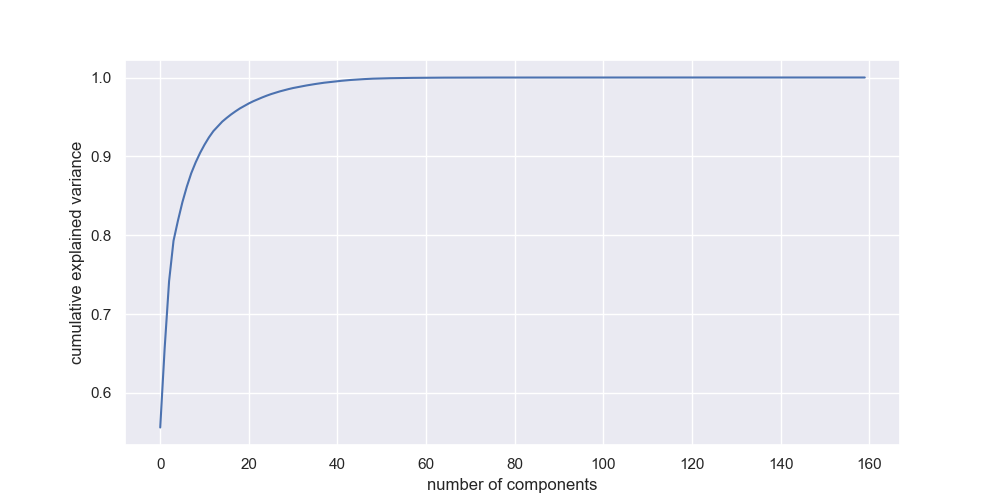

In [36]:
sns.set()
fig, ax = plt.subplots(figsize=(10,5))
pca = PCA().fit(X_dev)
ax.plot(np.cumsum(pca.explained_variance_ratio_))
ax.set_xlabel('number of components')
ax.set_ylabel('cumulative explained variance')

With just 40 components out of 160 we can explain around 99% of the variance!
Let's reduce the number of features.

In [44]:
pca = PCA(n_components=40)
X_train, X_test, y_train, y_test = train_test_split(X_dev, y_dev, test_size=0.2)
X_train_proj = pca.fit_transform(X_train)
X_test_proj = pca.transform(X_test)

3 - Use a Random forest classifier to fit and predict

In [45]:
param_grid = {
    'n_estimators': [int(x) for x in np.arange(50, 160, 10)],
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_features': ['sqrt', 'log2']
}

In [46]:
clf = RandomForestClassifier()
gridsearch = GridSearchCV(clf, param_grid, scoring='f1_macro', cv=5)
res = gridsearch.fit(X_train_proj, y_train)
print(f"Best parameters are: {res.best_params_}")
clf = res.best_estimator_
clf.fit(X_train_proj, y_train)
y_pred = clf.predict(X_test_proj)
_, _, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='macro')
print(f1)

Best parameters are: {'criterion': 'log_loss', 'max_features': 'log2', 'n_estimators': 140}
0.9558450897863187


4 - Compute y_eval

In [47]:
X_dev_proj = pca.fit_transform(X_dev)
X_eval_proj = pca.transform(X_eval)
clf.fit(X_dev_proj, y_dev)
y_eval = clf.predict(X_eval_proj)

In [48]:
dict = {'Id': np.arange(y_eval.shape[0]),
        'Predicted': y_eval.astype(int)}
df_eval = pd.DataFrame(dict)
df_eval.to_csv('eval.csv', encoding='utf-8', index=False)